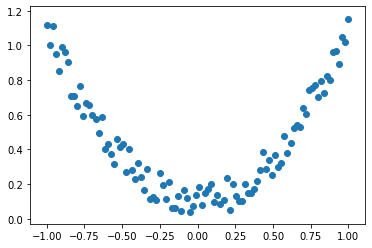

In [11]:
"""
使用神经网络来做回归问题
"""

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# print(torch.linspace(-1, 1, 100))
# 这里的转换是为了后续利用到Net中
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
# print(x)
y = x.pow(2) + 0.2*torch.rand(x.size())     # noisy y data (tensor), shape=(100, 1)
plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


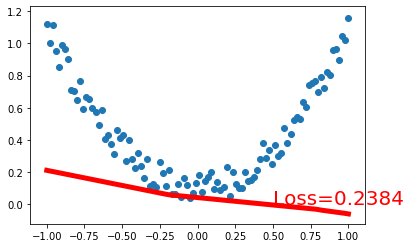

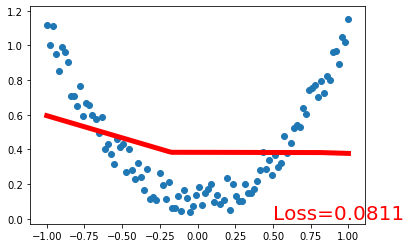

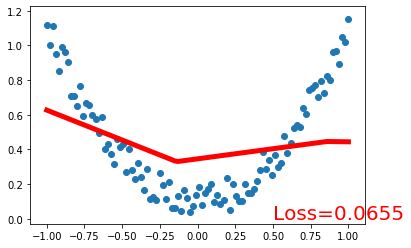

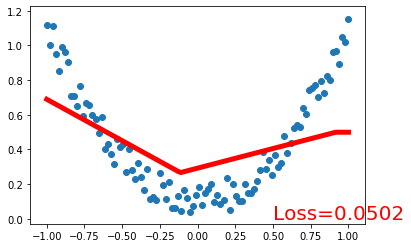

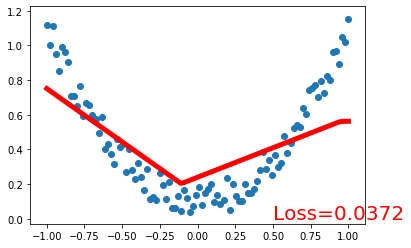

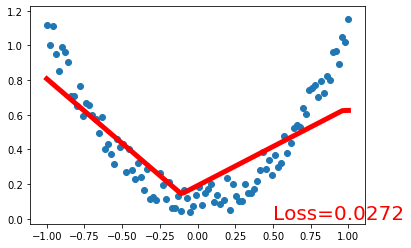

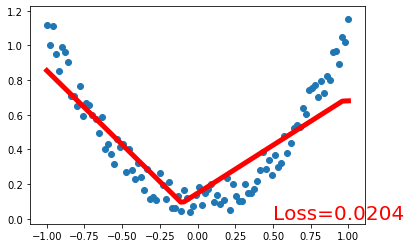

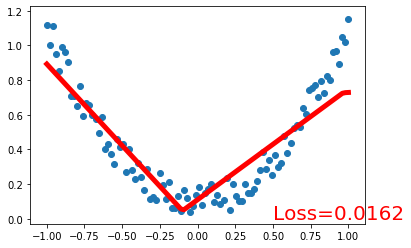

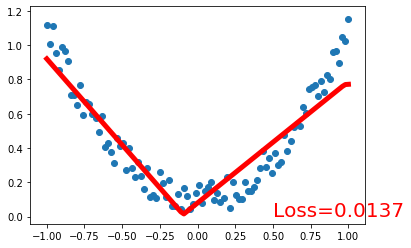

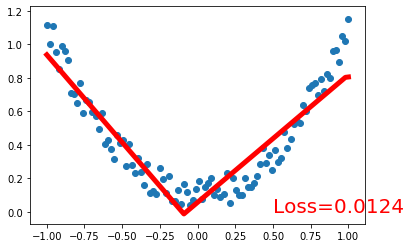

In [12]:
"""
每个网络定义都要实现两个函数
    init - 用来定义本Module要用到的东西
    forward - 定义具体的计算逻辑
"""
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        """借用了torch.nn.Linear，它实际上是使用了线性变换y=xA(T)+b。
        里面还有两个Variable, weight, bias。
        正如前面所说，要想更新权重，需要使用Variable
        """
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        """这里的计算逻辑是：
        dimision 1 -> dimision 10 使用的是第一个torch.nn.Linear
        relu 10 -> 10，激活函数
        dimision 10 -> 1 使用的是第二个torch.nn.Linear
        """
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting

for t in range(200):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 20 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


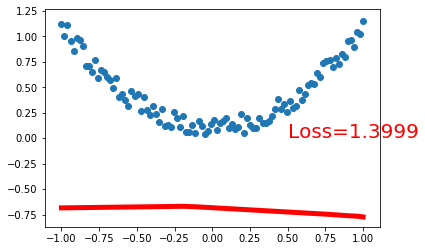

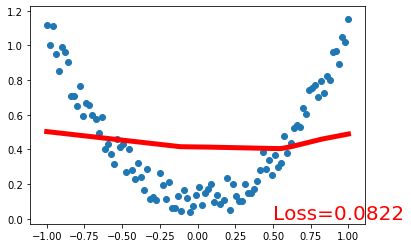

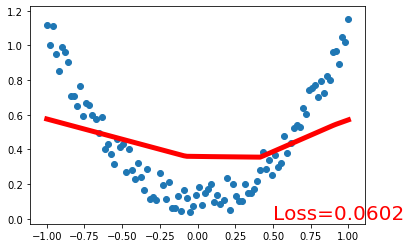

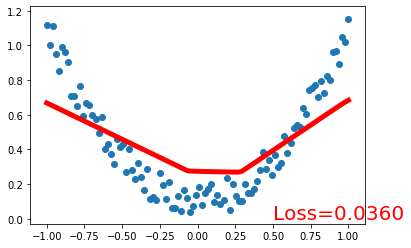

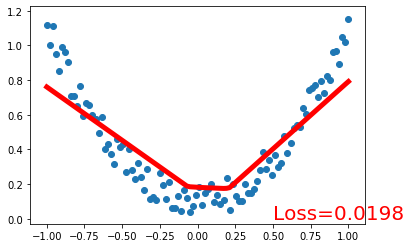

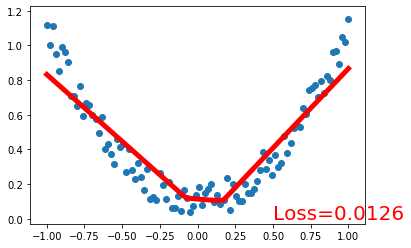

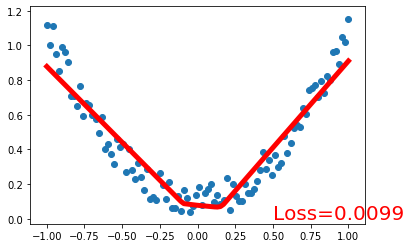

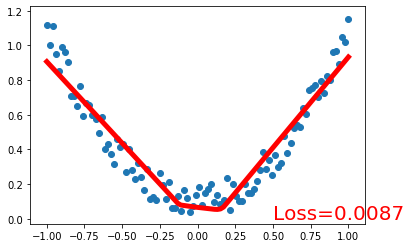

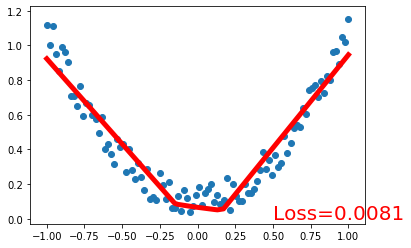

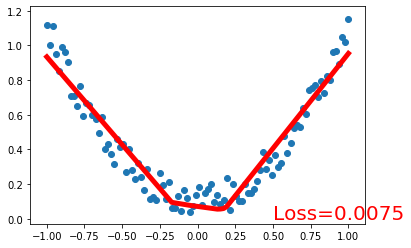

In [13]:
# 快速搭建一个与net1一样功能的网络. ReLU层也会被打印出来

net2 = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

print(net2)

optimizer2 = torch.optim.SGD(net2.parameters(), lr=0.2)
loss_func2 = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting

for t in range(200):
    prediction2 = net2(x)     # input x and predict based on x

    loss2 = loss_func2(prediction2, y)     # must be (1. nn output, 2. target)

    optimizer2.zero_grad()   # clear gradients for next train
    loss2.backward()         # backpropagation, compute gradients
    optimizer2.step()        # apply gradients

    if t % 20 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction2.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss2.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()